<a href="https://colab.research.google.com/github/Belashov641618/DNN/blob/main/collab/Incoherent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
!git clone https://github.com/Belashov641618/DNN.git

Cloning into 'DNN'...
remote: Enumerating objects: 637, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 637 (delta 113), reused 157 (delta 69), pack-reused 400
Receiving objects: 100% (637/637), 25.32 MiB | 24.70 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [3]:
!git pull

fatal: not a git repository (or any of the parent directories): .git


In [4]:
!dir
from google.colab import files
files.view('/content/DNN')
!dir

DNN  sample_data


<IPython.core.display.Javascript object>

DNN  sample_data


In [5]:
%cd DNN
import sys, os
sys.path.append(os.path.abspath('src'))

/content/DNN


In [6]:
!pip install belashovplot
from belashovplot.belashovplot import DefaultFont, DefaultBigHeader, DefaultHeader, DefaultDefault, DefaultCaption, DefaultSmallCaption
DefaultFont['font'] = 'DejaVu Sans'
for Font in [DefaultBigHeader, DefaultHeader, DefaultDefault, DefaultCaption, DefaultSmallCaption]:
  Font.Font = 'DejaVu Sans'

  Preparing metadata (setup.py) ... done
  Created wheel for belashovplot: filename=belashovplot-1.0-py3-none-any.whl size=12758 sha256=37d978ece05d0558e6e72570c7225e3370533e7137a2abeb64f78fda802eba0d
  Stored in directory: /root/.cache/pip/wheels/55/7b/e2/e5bf08c4c48d0989afbcb220497fa4bb6805a32f6c7826eece
Successfully built belashovplot


In [36]:
import torch
import numpy
from itertools import product
from belashovplot import TiledPlot
from src.utilities.Formaters import Format

In [8]:
from src.modules import layers
from src.utilities import decimal

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Просто задание рандомной фазы с помощью рандомной матрицы


In [14]:
torch.cuda.empty_cache()

pixels = 1023
wavelength = 532*decimal.nm
distance = 30.0*decimal.cm
length = 10*decimal.mm
samples = 10
padding = int(pixels*0.05)
focus = pixels*length*length / ((pixels*pixels - 1) * wavelength)
# 1/f = 1/a + 1/b -> 1/b = 1/f - 1/a -> b = af / (a - f)
distance = 2 * focus
distance_b = distance * focus / abs(distance - focus)

# distance = focus
# distance_b = focus

print(distance, distance_b, focus)

propagator = layers.FourierPropagationLayer(500.0*decimal.nm, 1.0, length, pixels, 1, distance, length).to(device)
propagator_b = layers.FourierPropagationLayer(500.0*decimal.nm, 1.0, length, pixels, 1, distance_b, length).to(device)
lens = layers.LensLayer(focus, wavelength, length, pixels, 1).to(device)
def model(data:torch.Tensor):
    return propagator_b(lens(propagator(data)))

from src.utilities.UniversalTestsAndOther import GenerateSingleUnscaledSampleMNIST
from torchvision.transforms.functional import resize, pad
from torchvision.transforms import InterpolationMode

with torch.no_grad():
  image = pad(resize(GenerateSingleUnscaledSampleMNIST(True).abs(), size=[pixels-2*padding, pixels-2*padding], interpolation=InterpolationMode.BICUBIC, antialias=True), [padding]*4, 0.)
  # image = torch.zeros_like(image)
  # s = 5
  # image[:,:, int(pixels/2)-s:int(pixels/2)+s, int(pixels/2)-s:int(pixels/2)+s] = 1.0
  coherent = image.clone().to(torch.complex64).to(device)
  incoherent = coherent.clone().expand(samples, 1, pixels, pixels) * torch.exp(2j*torch.pi*torch.rand(samples, 1, pixels, pixels, device=device, dtype=torch.float32))

  coherent_result = model(coherent)

  try_again = True
  split = 128
  while try_again:
    try:
      incoherent_results = torch.zeros_like(coherent_result, dtype=torch.float32)
      for part in torch.chunk(incoherent, split, dim=0):
          incoherent_results += torch.mean(torch.abs(model(part)), dim=0)
      incoherent_results /= split
      try_again = False
    except RuntimeError as e:
      split *= 2
      print(f'Split: {split}')

  M = pixels
  Na = int(M*distance/(distance+distance_b))
  Nb = int(M*distance_b/(distance+distance_b))
  cut = torch.zeros(Na + Nb, pixels)
  distances = numpy.linspace(0, distance, Na+1)[:-1]
  for i, distance_ in enumerate(distances):
    coherent_ = propagator(coherent)
    propagator.distance = distance_
    cut[i] = torch.abs(coherent_.squeeze()[int(pixels/2)].cpu())
  coherent_ = lens(coherent_)
  distances = numpy.linspace(0, distance_b, Nb)
  for i, distance_ in enumerate(distances, start=Na):
    propagator_b.distance = distance_
    cut[i] = torch.abs(propagator_b(coherent_).squeeze()[int(pixels/2)].cpu())

  coherent = coherent.squeeze().cpu()
  coherent_result = coherent_result.squeeze().cpu()
  incoherent_results = incoherent_results.squeeze().cpu()
  cut = cut.squeeze().cpu()

0.3674879851904712 0.3674879851904712 0.1837439925952356


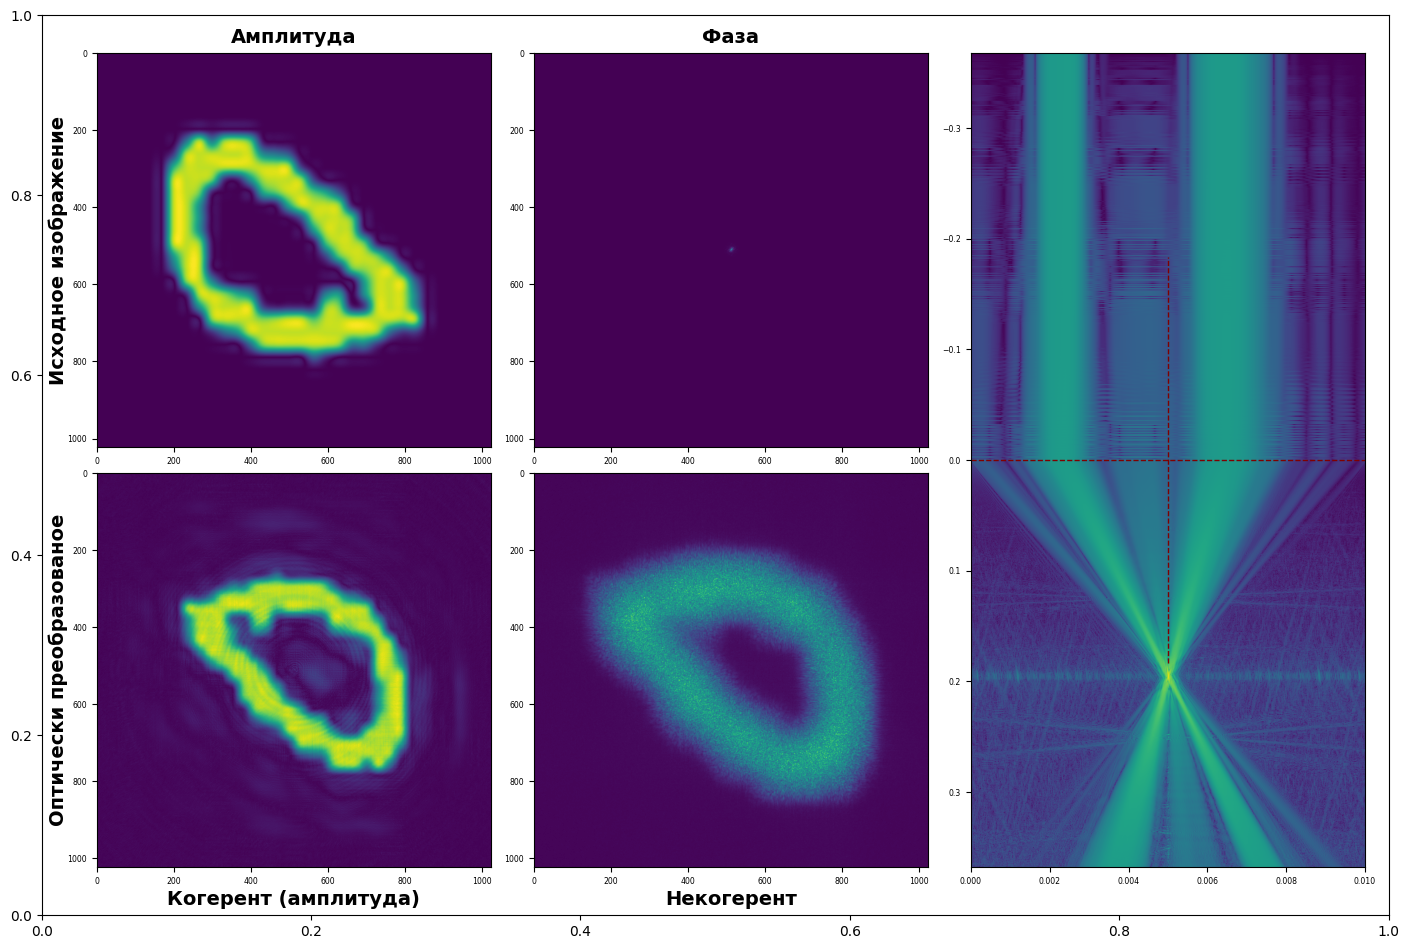

In [15]:
from belashovplot import TiledPlot

plot = TiledPlot(16,9)
plot.FontLibrary.MultiplyFontSize(0.7)

plot.description.row.left('Исходное изображение', 0)
plot.description.row.left('Оптически преобразованое', 1)
plot.description.column.top('Амплитуда', 0)
plot.description.column.top('Фаза', 1)
plot.description.column.bottom('Когерент (амплитуда)', 0)
plot.description.column.bottom('Некогерент', 1)

kwargs = {'aspect':'auto', 'cmap':'viridis'}

axes = plot.axes.add(0,0)
axes.imshow(torch.abs(coherent), **kwargs)

axes = plot.axes.add(1,0)
axes.imshow(torch.abs(torch.fft.fftshift(torch.fft.fft2(coherent))), **kwargs)

axes = plot.axes.add(0,1)
axes.imshow(torch.abs(coherent_result), **kwargs)

axes = plot.axes.add(1,1)
axes.imshow(incoherent_results, **kwargs)

axes = plot.axes.add((2,0), (2, 1))
axes.imshow(torch.log10(cut + 0.005), **kwargs, extent=[0, length, distance_b, -distance])
axes.axvline(length/2, (distance_b-focus)/(distance + distance_b), (distance_b+focus)/(distance + distance_b), color='maroon', linestyle='--', linewidth=1.0)
axes.axhline(0, color='maroon', linestyle='--', linewidth=1.0)

plot.show()

# Задание фазы ввиде случайного процесса

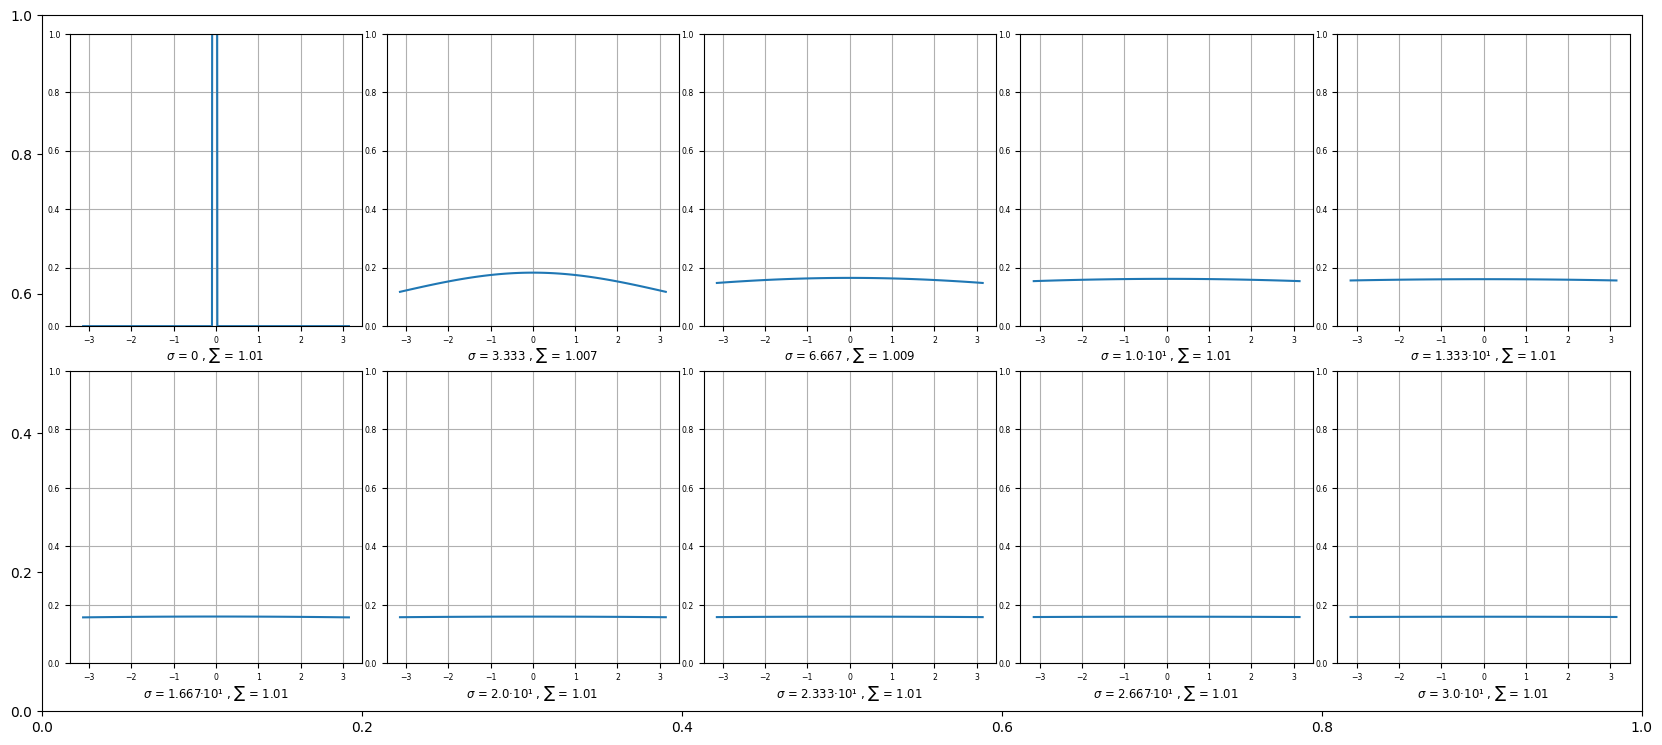

In [59]:
def modified_gauss(sigma_array:torch.Tensor, x_array:torch.Tensor):
  sigma_mesh, x_mesh = torch.meshgrid(sigma_array, x_array, indexing='ij')
  limits = torch.zeros_like(x_mesh, device=x_array.device)
  index = torch.abs(x_array).argmin()
  limits[:, index] = 1.0 * x_array.size(0) / (x_array[-1] - x_array[0])
  return torch.where(sigma_mesh != 0, torch.exp(-0.5*(x_mesh/sigma_mesh)**2) / (numpy.sqrt(2*torch.pi)*sigma_mesh*torch.erf(torch.pi / (numpy.sqrt(2)*sigma_mesh))), limits)



rows = 2
cols = 5

sigma_limits = (0, 30)
sigma_count = int(rows * cols)
sigma_array = torch.linspace(*sigma_limits, sigma_count, device=device)

x_limits = (-torch.pi, +torch.pi)
x_count = 100
x_array = torch.linspace(*x_limits, x_count, device=device)

results = modified_gauss(sigma_array, x_array)

plot = TiledPlot(16, 8)
plot.FontLibrary.MultiplyFontSize(0.7)
for (row, col), data, sigma in zip(product(range(rows), range(cols)), results, sigma_array):
  axes = plot.axes.add(col, row)
  axes.plot(x_array.cpu(), data.cpu())
  axes.grid(True)
  axes.set_ylim(0.,1.)
  plot.graph.description(f"$\sigma$ = {Format.Scientific(sigma.item())}, $\sum$ = {Format.Scientific((torch.sum(data) * (x_array[1] - x_array[0])).item())}")

plot.show()